In [ ]:
# Pytorch can be installed with the interactive selector:
# https://pytorch.org/get-started/locally/#windows-anaconda

# Note the GPU version requires cuda 12.1
# NOT cuda 12.3 (the latest version as of 2/1/24)
# Can be found here: https://developer.nvidia.com/cuda-12-1-0-download-archive

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import pandas as pd
# Here are some tools for gpu usage if you want to play with it:
# You can check if you have gpu setup and available here:
#print(torch.version.cuda)
#print(torch.cuda.is_available())

# However, in this case the gpu will likely be slower
# If you want to try it out uncomment this line, and then a few lines in the training section
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Load the dataset
# Load data, but skip the header
# dataset = np.loadtxt('card_transdata.csv', delimiter=',', skiprows = 1, dtype=np.float32)
dataset = pd.read_csv('creditcard.csv', delimiter=',', dtype=np.float32)
dataset = dataset.to_numpy()
# print(dataset[0:5])
# get the number of data points and number of features
[num_datums, num_features] = dataset.shape

# The number of features is actually 1 less, because one of the columns is dedicated to the label
# num_features -= 1

# Shuffle the data in case somebody has it in an ordered list
np.random.shuffle(dataset)

In [4]:
# Now discretize for training, evaluating, validating
training_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

num_train = round(num_datums * training_ratio)
num_valid = round(num_datums * validation_ratio)
num_test = round(num_datums * test_ratio)

# Create all of the split datasets as numpy arrays
X_training_np = dataset[0:num_train, 0:num_features]
y_training_np = dataset[0:num_train, -1]

X_validation_np = dataset[num_train:num_train+num_valid, 0:num_features]
y_validation_np = dataset[num_train:num_train+num_valid, -1]

X_test_np = dataset[num_train+num_valid:, 0:num_features]
y_test_np = dataset[num_train+num_valid:, -1]

In [5]:
# Convert the numpy arrays into torch tensors (pretty much the same thing)
X_training = torch.from_numpy(X_training_np)
y_training = torch.from_numpy(y_training_np).reshape(-1,1)

In [6]:
# Create our network
neural_network = torch.nn.Sequential(
    torch.nn.Linear(num_features,12),
    torch.nn.ReLU(),
    torch.nn.Linear(12,8),
    torch.nn.ReLU(),
    torch.nn.Linear(8,1),
    torch.nn.Sigmoid()
)

# Another approach that is easy to modify number of hidden_layers:
#num_hidden_layers = 4
#num_hidden_nodes = 12
#
#initial_layer = torch.nn.Linear(num_features, num_hidden_nodes)
#layer_list = [initial_layer]
#
#for i in range(num_hidden_layers-1):
#    layer_list.append( torch.nn.ReLU() )
#    layer_list.append( torch.nn.Linear(num_hidden_nodes,num_hidden_nodes))
#
#layer_list.append( torch.nn.ReLU() )
#layer_list.append( torch.nn.Linear(num_hidden_nodes, 1))
#layer_list.append( torch.nn.Sigmoid() )
#
#neural_network = torch.nn.Sequential(*layer_list)

In [7]:
# Define other parameters of the network
loss_function = torch.nn.BCELoss() # Binary cross entropy
optimizer = torch.optim.Adam(neural_network.parameters())

In [ ]:
# If you want to try using the gpu then uncomment here:
# Send our tensors to the gpu if it is available
#X_training = X_training.to(device)
#y_training = y_training.to(device)

# Send the model to the gpu
#neural_network.to(device)

In [8]:
# grid search done here:
# i am changing the learning rate and the batch size 
from sklearn.model_selection import ParameterGrid
from torch.nn import BCELoss








In [37]:
# Train your model

# NOTE: Something cool about pytorch is that it is dynamically updating the model, so
# if you interrupt the script it saves the models current state and you can move on to
# validating

# num_epochs = 20
# batch_size = 1000
# num_batches = round(num_train/batch_size)
def train_model(neural_network, X, y, loss_fn, optimizer, num_epochs, batch_size):
    # Determine number of batches
    num_batches = round(X.size(0)/batch_size)
    
    for epoch in range(num_epochs):
        total_correct = 0
        t = time.time() # Measure the time of the epoch
        for batch in range(num_batches):
            # Get a batch of the training data
            X_batch = X[batch*batch_size:(batch+1)*batch_size]
            y_batch = y[batch*batch_size:(batch+1)*batch_size]

            # Deploy the model
            y_prediction = neural_network(X_batch)

            # Compute loss
            loss = loss_fn(y_prediction, y_batch)
            
            
            acurracy = (y_prediction.round() == y_batch).float().sum()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute the time of the epoch
        elapsed_time = time.time() - t

        # Print results of epoch
        print(f'Epoch {epoch+1}/{num_epochs} completed in {elapsed_time:.2f}s, loss {loss:.4f}')

    return loss.item(), elapsed_time, acurracy.item()

In [39]:
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize
from botorch.acquisition import UpperConfidenceBound
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch

# Define a function that trains your model and returns the validation error
def train_and_validate(learning_rate, batch_size):
    # Convert hyperparameters to integer if necessary
    batch_size = int(batch_size)

    # Initialize optimizer
    optimizer = torch.optim.Adam(neural_network.parameters(), lr=learning_rate)

    # Apply the loss function
    loss_fn = torch.nn.BCELoss()

    # Train the model and get the validation error
    _, _, validation_error = train_model(neural_network, X_training, y_training, loss_fn, optimizer, num_epochs=100, batch_size=batch_size)

    # Return the negative validation error because Bayesian Optimization maximizes the function
    return -validation_error

# Define the bounds of the hyperparameters to optimize
bounds = torch.tensor([[0.001, 16], [0.1, 64]])

# Initialize an empty tensor for storing observations
X = torch.empty(0, 2)
Y = torch.empty(0, 1)

# Perform Bayesian Optimization
for i in range(20):
    # Fit a GP model to the observations
    gp = SingleTaskGP(X, Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)

    # Define the acquisition function
    ucb = UpperConfidenceBound(gp, beta=2.0)

    # Optimize the acquisition function to find the next hyperparameters to try
    new_X = optimize(ucb, bounds=bounds, q=1, num_restarts=5, raw_samples=20)

    # Train the model with the new hyperparameters and get the validation error
    new_Y = train_and_validate(new_X[0, 0], new_X[0, 1])

    # Add the new observation to the dataset
    X = torch.cat([X, new_X])
    Y = torch.cat([Y, new_Y])

# Print the best hyperparameters
best_X = X[Y.argmax(), :]
print(best_X)

/Users/joel-carlson/miniconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/joel-carlson/miniconda3/envs/ML/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/Users/joel-carlson/miniconda3/envs/ML/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/run

RuntimeError: cannot reshape tensor of 0 elements into shape [-1, 0, 0] because the unspecified dimension size -1 can be any value and is ambiguous

In [29]:
# Evaluate model
# Convert the data to tensors
X_validation = torch.from_numpy(X_validation_np)
y_valdation = torch.from_numpy(y_validation_np).reshape(-1,1)

# Run the model
y_prediction = neural_network(X_validation)
# Round the results
y_prediction = y_prediction.round()

# See how many are different
num_matches = sum(y_prediction==y_valdation)

# Compute accuracy
accuracy = float(num_matches/num_valid)

print(f"Accuracy {accuracy:.5f}")
df = pd.DataFrame(results)
print(df.columns)

Accuracy 0.99817
Index(['params', 'loss', 'accuracy', 'optimizer'], dtype='object')


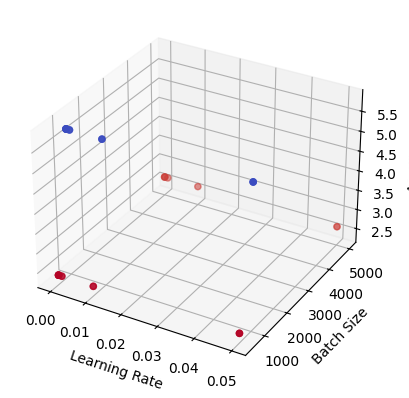

In [26]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # Make data.
# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))waht 
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()

# Above code is an example i found online that i wanted to try out for 3d plotting
df['learning_rate'] = df['params'].apply(lambda x: x['learning_rate'])
df['batch_size'] = df['params'].apply(lambda x: x['batch_size'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# use the newly created columns
X = df['learning_rate']
Y = df['batch_size']
Z = df['accuracy']

ax.scatter(X, Y, Z, c=Z, cmap='coolwarm_r')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Accuracy')

plt.show()



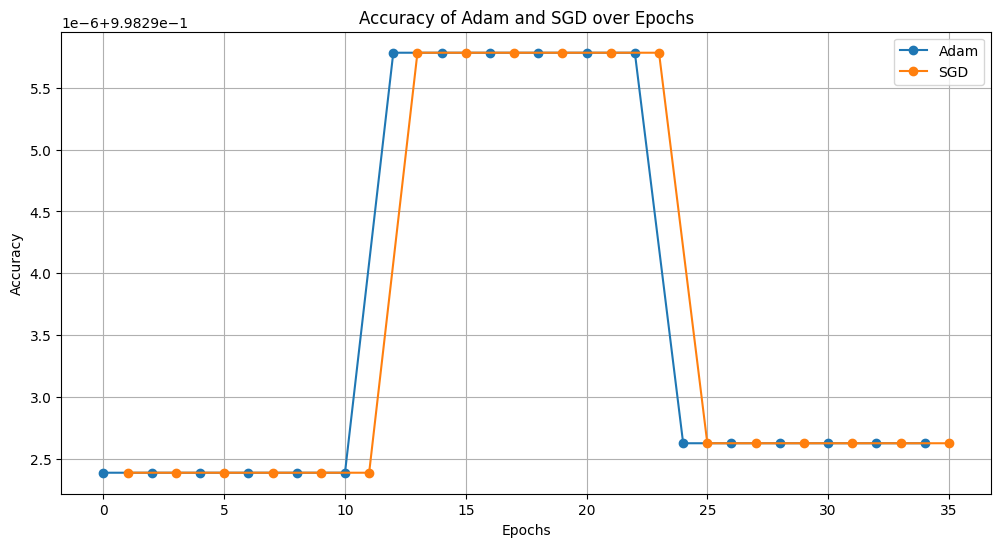

In [32]:
# Ploting optimizers vs accuracy by num epochs
df_adam = df[df['optimizer'] == 'Adam']
df_sgd = df[df['optimizer'] == 'SGD']

plt.figure(figsize=(12, 6))

# Plot accuracy over epochs for Adam
plt.plot(df_adam.index, df_adam['accuracy'], label='Adam', marker='o') 

# Plot accuracy over epochs for SGD
plt.plot(df_sgd.index, df_sgd['accuracy'], label='SGD', marker='o') 

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of Adam and SGD over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# DON'T TOUCH THIS UNTIL YOU ARE DONE TUNING YOUR HYPERPARAMETERS
# Convert the data to tensors
#X_test = torch.from_numpy(X_test_np)
#y_test = torch.from_numpy(y_test_np).reshape(-1,1)

# Run the model
#y_prediction = neural_network(X_test)
# Round the results
#y_prediction = y_prediction.round()

# See how many are different
#num_matches = sum(y_prediction==y_test)

# Compute accuracy
#accuracy = float(num_matches/num_test)

#print(f"Final Accuracy {accuracy:.5f}")